In [188]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from scipy.stats import wasserstein_distance
import random
from tqdm import tqdm

#### 1.- Calculador de distancias arbitrarias

In [189]:
class DistanceType(Enum):
    """
    Tipos de distancia a utilizar
    1.- Manhattan
    2.- Euclidiana
    3.- Wasserstein
    4.- Coseno
    """
    MANHATTAN = 0
    EUCLIDEAN = 1
    WASSERSTEIN = 2
    COSINE = 3


In [190]:
class DistanceCalculator:
    """
    Clase utilizada para calcular las distancias
    """
    def manhattanDistance(self, vector1, vector2):
        n1 = len(vector1)
        n2 = len(vector2)
        #Si los vectores no son de igual dimensión vamos a mandar un 
        #mensaje al usuario
        if(n1 != n2):
            print("Los vectores deben ser de la misma dimensión")
            return -1
        d = 0
        for i in range(0,n1):
            d += np.abs(vector1[i] - vector2[i])
    
        return d


    def euclideanDistance(self, vector1, vector2):
        n1 = len(vector1)
        n2 = len(vector2)
    
        if(n1 != n2):
            print("Los vectores deben ser de la misma dimensión")
            return -1
    
        d = 0
        for i in range(0,n1):
            d += (vector1[i] - vector2[i])**2
    
        d = np.sqrt(d)
        return d


    def cosineDistance(self, vector1, vector2):
        n1 = len(vector1)
        n2 = len(vector2)
    
        if(n1 != n2):
            print("Los vectores deben ser de la misma dimensión")
            return -1
    
        #Obtenemos el producto punto y las dos normas
        dotProduct = 0
        norm1 = 0
        norm2 = 0
        for i in range(0,n1):
            dotProduct += vector1[i]*vector2[i]
            norm1 += vector1[i]**2
            norm2 += vector2[i]**2
    
        norm1 = np.sqrt(norm1)
        norm2 = np.sqrt(norm2)
    
        cosineDistance = 1 - (dotProduct/(norm1*norm2))
        return cosineDistance
    
    #Metodos necesarios para calcular la distancia Wasserstein
    def generateDataWithDistribution(self,distribution, nData):
        distribution = np.array(distribution)/sum(distribution)
        cumulativeDistribution = np.zeros(len(distribution) + 1)
        #Calculamos la distribución acumulada
        for i in range(1, len(cumulativeDistribution)):
            cumulativeDistribution[i] = cumulativeDistribution[i - 1] + distribution[i-1]

        generatedData = []
        for i in range(0,nData):
            diceRoll = random.random()
            index = 0
            for j in range(1, len(cumulativeDistribution)):
                if(diceRoll >= cumulativeDistribution[j-1] and diceRoll<= cumulativeDistribution[j]):
                    index = j-1
                    generatedData.append(index)
                    break
    
        return generatedData
    
    def wassersteinDistance(self, vector1, vector2):
        data1 = self.generateDataWithDistribution(vector1, 1000)
        data2 = self.generateDataWithDistribution(vector2, 1000)
        return wasserstein_distance(data1, data2)
    
    
    def computeDistance(self, distanceType, vector1, vector2):
        if(distanceType == DistanceType.MANHATTAN):
            return self.manhattanDistance(vector1, vector2)
        elif(distanceType == DistanceType.EUCLIDEAN):
            return self.euclideanDistance(vector1, vector2)
        elif(distanceType == DistanceType.WASSERSTEIN):
            return self.wassersteinDistance(vector1, vector2)
        elif(distanceType == DistanceType.COSINE):
            return self.cosineDistance(vector1, vector2)

In [191]:
#Pequeña prueba del calculador de distancias

vector1 = np.array([5,2,4])
vector2 = np.array([1,2,4])

distanceCalculator = DistanceCalculator()
print("Euclidean distance "+str(distanceCalculator.computeDistance(DistanceType.EUCLIDEAN, vector1, vector2)))
print("Manhattan distance "+str(distanceCalculator.computeDistance(DistanceType.MANHATTAN, vector1, vector2)))
print("Wasserstein distance "+str(distanceCalculator.computeDistance(DistanceType.WASSERSTEIN, vector1, vector2)))
print("Cosine distance " + str(distanceCalculator.computeDistance(DistanceType.COSINE, vector1, vector2)))


Euclidean distance 4.0
Manhattan distance 4
Wasserstein distance 0.502
Cosine distance 0.18674993920955574


#### 2.- LOF

In [193]:
class LOFArbitraryDistance:
    
    def __init__(self, data, distanceType, minPoints):
        """
        data: una tabla de datos donde cada fila es un vector
        """
        self.data = data
        self.distanceType = distanceType
        #Para no tener que crear demasiados calculadores de distancia
        #Creare uno que usaré en los distintos métodos del objeto.
        self.distanceCalculator = DistanceCalculator()
        self.minPoints = minPoints
    
    def getKDistance(self, point):
        nData = np.size(self.data, 0)
        kCounter = 0
        foundVectors = []
        distanceSoFar = 0
        for i in range(0,self.minPoints):
            minDist = float('inf')
            minVector = None
            for j in range(0,nData):
                vector = self.data[j,:]
                d = self.distanceCalculator.computeDistance(self.distanceType, vector, point) 
                if(not list(vector) in foundVectors and d <= minDist):
                    minVector = vector
                    minDist = d
                
            foundVectors.append(list(minVector))
            distanceSoFar = minDist
        
        return distanceSoFar
    #Para usar este metodo hay que obtener primero la distancia k
    def getNeighborhood(self, point, kDistance):
        neighbors = []
        nData = np.size(self.data, 0)
        for i in range(0,nData):
            vector = self.data[i,:]
            if(self.distanceCalculator.computeDistance(self.distanceType, point,vector) <= kDistance):
                neighbors.append(vector)
        
        return neighbors
    
    def getReachabilityDistance(self, point, neighbor):
        d = self.distanceCalculator.computeDistance(self.distanceType, point, neighbor)
        kDistance = self.getKDistance(neighbor)
        return np.max([d, kDistance])
    
    def getLocalReachabilityDistance(self, point):
        pointKDistance = self.getKDistance(point)
        #Obtenemos los puntos del k-vecindario
        neighbors = self.getNeighborhood(point, pointKDistance)
        nNeighbors = len(neighbors)
        lrd = 0
        for i in range(0,nNeighbors):
            neighbor = neighbors[i]
            reachDist = self.getReachabilityDistance(point, neighbor)
            lrd = lrd + reachDist/nNeighbors
        lrd = 1/lrd
        return lrd
    
    
    def getLOFScore(self, point):
        lrdPoint = self.getLocalReachabilityDistance(point)
        pointKDistance = self.getKDistance(point)
        neighbors = self.getNeighborhood(point, pointKDistance)
        nNeighbors = len(neighbors)
        lofScore = 0
        for i in range(0,nNeighbors):
            neighbor = neighbors[i]
            lrdNeighbor = self.getLocalReachabilityDistance(neighbor)
            lofScore = lofScore + lrdNeighbor/lrdPoint
        
        return lofScore/nNeighbors
    
    def computeAllLOFScores(self):
        lofScores = []
        for i in tqdm(range(0,np.size(self.data, 0))):
            lofScores.append(self.getLOFScore(self.data[i,:]))
        
        return lofScores    
    

#### Probemos el algoritmo LOF en un conjunto sintético de datos

In [194]:
def createLabyrinthPoints(nPoints, nAnnulus, maxRadius):
    delta = maxRadius/(2*nAnnulus)
    annulusBoundaries = []
    distanceCalculator = DistanceCalculator()
    for i in range(0,nAnnulus):
        if(i%2 == 0):
            annulusBoundaries.append([i*delta, (i+1)*delta])
    points = []
    while(len(points) < nPoints):
        newPoint = [-maxRadius + 2*random.random()*maxRadius, -maxRadius + 2*random.random()*maxRadius]
        normPoint = distanceCalculator.euclideanDistance(newPoint, [0,0])
        for j in range(0,len(annulusBoundaries)):
            boundaries = annulusBoundaries[j]
            if(normPoint >= boundaries[0] and normPoint <= boundaries[1]):
                points.append(newPoint)
    return np.array(points)

In [195]:
points = createLabyrinthPoints(2000, 5, 10)

(-5.468806746109454, 5.449491257772479, -5.459563202859121, 5.470470834652822)

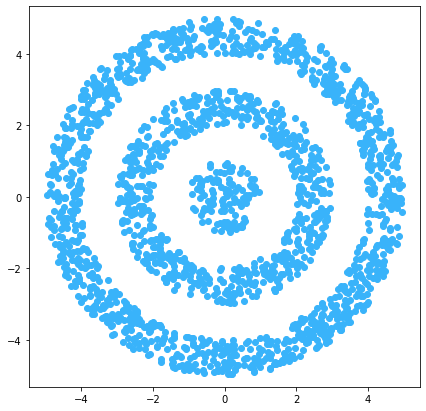

In [196]:
plt.figure(figsize = (7,7))
plt.plot(points[:,0], points[:,1], color = "#39b3fa", marker = "o", linestyle = "none")
plt.axis('equal')

(-5.621146496866016, 8.648626023660286, -5.459563202859121, 5.470470834652822)

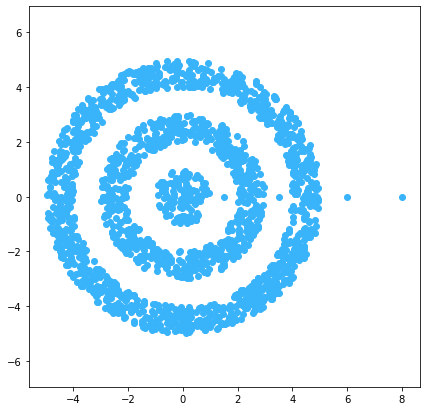

In [197]:
#Agreguemos un par de puntos anomalos anomalo
points = list(points)
points.append([1.5,0])
points.append([3.5,0])
points.append([6,0])
points.append([8,0])
points = np.array(points)

plt.figure(figsize = (7,7))
plt.plot(points[:,0], points[:,1], color = "#39b3fa", marker = "o", linestyle = "none")
plt.axis('equal')

In [198]:
class ColorGenerator:
    #Regresa un esquema de colores aleatorio    
    def buildRandomScheme(self, numberOfColors):
        colorStrings = []
        for i in range(0,numberOfColors):
            colorStrings.append(self.getRandomColor())
            
        return colorStrings
        
    def getRandomColor(self):
        s = "#"
        r = str(hex(randrange(16)))[-1:] + str(hex(randrange(16)))[-1:]
        g = str(hex(randrange(16)))[-1:] + str(hex(randrange(16)))[-1:]
        b = str(hex(randrange(16)))[-1:] + str(hex(randrange(16)))[-1:]
        s = s+r+g+b
        
        return s
    
    def hex2Vector(self, value):
        r = int(value[1:3],16)
        g = int(value[3:5],16)
        b = int(value[5:7],16)
        
        return np.array([r,g,b])
    
    def getGradientColor(self, startColor, endColor, value, minValue, maxValue):
        color = startColor + ((value - minValue)/(maxValue - minValue))*(endColor - startColor)
        
        s = '#%02x%02x%02x' % (int(color[0]), int(color[1]), int(color[2]))
        return s

In [199]:
class ColorPointPlotter:
    
    def plotPointsWithColors(self, points, values, minColor, maxColor, title, ax):
        nPoints = np.size(points, 0)
        maxValue = np.max(values)
        minValue = np.min(values)
        colorGenerator = ColorGenerator()
        maxRegistered = False
        minRegistered = False
        
        for i in range(0,nPoints):
            point = points[i,:]
            pointColor = colorGenerator.getGradientColor(minColor, maxColor, values[i], minValue, maxValue)
            if(not maxRegistered and values[i] == maxValue):
                ax.plot(point[0], point[1], color = pointColor, marker = "o", linestyle = "none", label = "Max val. "+str(round(maxValue,2)))
                maxRegistered = True
            elif(not minRegistered and values[i] == minValue):
                ax.plot(point[0], point[1], color = pointColor, marker = "o", linestyle = "none", label = "Min val. "+str(round(minValue,2)))
                minRegistered = True
            else:
                ax.plot(point[0], point[1], color = pointColor, marker = "o", linestyle = "none")
        
        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        
        ax.legend()
        
    def plotPointsWithColorsMinMax(self, points, values, minColor, maxColor,minValue, maxValue, title, ax):
        nPoints = np.size(points, 0)
        colorGenerator = ColorGenerator()
        maxRegistered = False
        minRegistered = False
        firstPoint = points[0,:]
        ax.plot(firstPoint[0],firstPoint[1],color = maxColor/255, linestyle = "none", marker = "o", label = "Max val. "+str(round(maxValue, 2)))
        ax.plot(firstPoint[0],firstPoint[1], color = minColor/255, linestyle = "none", marker = "o", label = "Min val. "+str(round(minValue, 2)))
        for i in range(0,nPoints):
            point = points[i,:]
            pointColor = colorGenerator.getGradientColor(minColor, maxColor, values[i], minValue, maxValue)
            ax.plot(point[0], point[1], color = pointColor, marker = "o", linestyle = "none")
        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        
        ax.legend()

In [200]:
distanceType = DistanceType.EUCLIDEAN
minPoints = 4

lofArbitraryDistance = LOFArbitraryDistance(points, distanceType, minPoints)

In [201]:
anomalyScores = lofArbitraryDistance.computeAllLOFScores()

100%|██████████████████████████████████████████████████████████████████████████████| 2004/2004 [36:14<00:00,  1.09s/it]


Text(7.7, 0.3, '11.73')

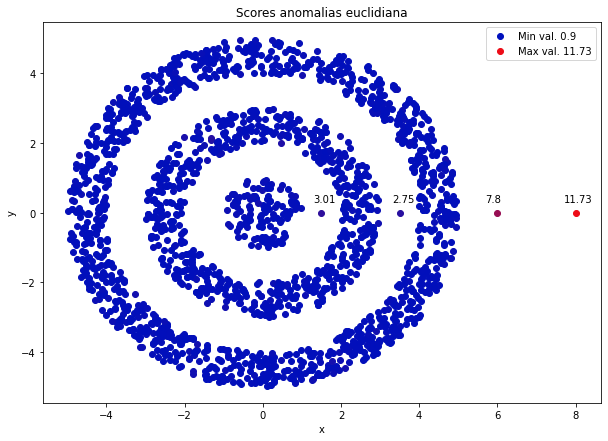

In [218]:
colorPlotter = ColorPointPlotter()
minColor = np.array([0, 16, 189])
maxColor = np.array([237, 12, 23])

fig,ax = plt.subplots(figsize = (10,7))

colorPlotter.plotPointsWithColors(points, anomalyScores, minColor, maxColor,"Scores anomalias euclidiana" , ax)
ax.text(1.3,0.3,str(round(anomalyScores[-4],2)))
ax.text(3.3,0.3,str(round(anomalyScores[-3],2)))
ax.text(5.7, 0.3,str(round(anomalyScores[-2],2)))
ax.text(7.7, 0.3,str(round(anomalyScores[-1],2)))

In [220]:
distanceType = DistanceType.MANHATTAN
minPoints = 4

lofArbitraryDistance = LOFArbitraryDistance(points,distanceType, minPoints)


In [221]:
anomalyScores = lofArbitraryDistance.computeAllLOFScores()

100%|██████████████████████████████████████████████████████████████████████████████| 2004/2004 [36:55<00:00,  1.11s/it]


Text(7.7, 0.3, '14.9')

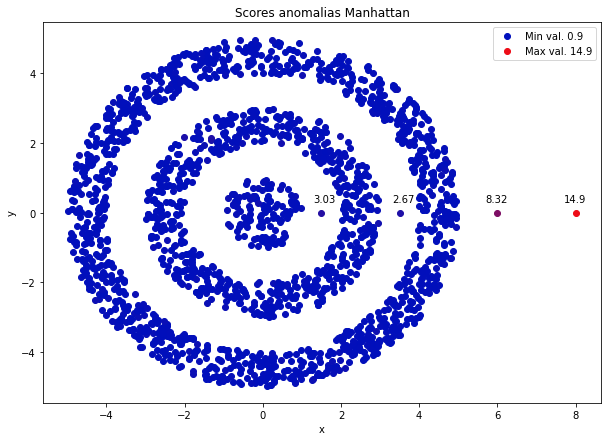

In [222]:
colorPlotter = ColorPointPlotter()
minColor = np.array([0, 16, 189])
maxColor = np.array([237, 12, 23])

fig,ax = plt.subplots(figsize = (10,7))

colorPlotter.plotPointsWithColors(points, anomalyScores, minColor, maxColor,"Scores anomalias Manhattan" , ax)
ax.text(1.3,0.3,str(round(anomalyScores[-4],2)))
ax.text(3.3,0.3,str(round(anomalyScores[-3],2)))
ax.text(5.7, 0.3,str(round(anomalyScores[-2],2)))
ax.text(7.7, 0.3,str(round(anomalyScores[-1],2)))